In [38]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import vgg19
from torch import optim
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from torch import Tensor
from IPython.display import clear_output
import torch.backends.cudnn as cudnn


In [39]:

from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [40]:

seed = 420
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
cudnn.benchmark = True
# cudnn.benchmark = False

#empty cuda cache


class Config:

    num_workers = 2
    epochs = 100
    batch_size = 27
    upscale_factor = 2
    gt_image_size = 256
    channels = 64
    in_channels = 3
    out_channels = 3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # device = "cpu"

    d_arch_name = "discriminator"
    g_arch_name = "srresnet_x4"
    num_rcb = 8
    exp_name = "SRGAN"
    train_gt_images_dir = f"/content/gdrive/My Drive/AI534/dataset/train/high_res"
    train_lr_images_dir = f"/content/gdrive/My Drive/AI534/dataset/train/low_res"
    test_gt_images_dir = f"/content/gdrive/My Drive/AI534/dataset/test/high_res"
    test_lr_images_dir = f"/content/gdrive/My Drive/AI534/dataset/test/low_res"
    root_dir = f"/content/gdrive/My Drive/AI534/dataset"


    # Loss function weight
    # pixel_weight = 1.0
    # content_weight = 1.0
    # # adversarial_weight = 0.001
    # adversarial_weight = 0.01

    # Feature extraction layer parameter configuration
    feature_model_extractor_node = "features.35"
    feature_model_normalize_mean = [0.485, 0.456, 0.406]
    feature_model_normalize_std = [0.229, 0.224, 0.225]

    # Optimizer parameter
    model_lr = 3e-4
    model_betas = (0.9, 0.999)
    model_eps = 1e-8
    model_weight_decay = 0.0


    # Dynamically adjust the learning rate policy [100,000 | 200,000]
    lr_scheduler_step_size = epochs//2
    lr_scheduler_gamma = 0.1
    #  How many iterations to print the training result
    train_print_frequency = 100
    valid_print_frequency = 1
    visualize_frequency = 1

    LOAD_MODEL = True
    SAVE_MODEL = True
    CHECKPOINT_GEN = "gen.pth.tar"
    CHECKPOINT_DISC = "disc.pth.tar"



In [41]:
class ImageDataset(Dataset):
    # This is a custom dataset created using pytorch Dataset
    def __init__(self, root_dir,low_res_dir,high_res_dir):
        super(ImageDataset, self).__init__()
        self.data = []
        self.root_dir = root_dir
        #Sort the files in the directory
        files_low = sorted(os.listdir(low_res_dir))
        files_high = sorted(os.listdir(high_res_dir))
        self.data = list(zip(files_low, files_high))

        low_res_size = Config.gt_image_size // Config.upscale_factor
        high_res_size = Config.gt_image_size
        self.transform_low = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((low_res_size, low_res_size)),
            transforms.ToTensor(),
        ])

        self.transform_high = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((high_res_size, high_res_size)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_low_file, img_high_file = self.data[index]

        # Get the path for the image LR and HR
        low_res_pth = os.path.join(self.root_dir, "low_res", img_low_file)
        high_res_pth = os.path.join(self.root_dir, "high_res", img_high_file)

        # Open the actual image
        low_res = np.array(Image.open(low_res_pth))
        high_res = np.array(Image.open(high_res_pth))

        # Discarding the alpha channel to make the model more optimized for memory
        low_res = low_res[:, :, :3]
        high_res = high_res[:, :, :3]

        # Apply the transformation to the image
        low_res = self.transform_low(low_res)
        high_res = self.transform_high(high_res)

        return low_res, high_res

100


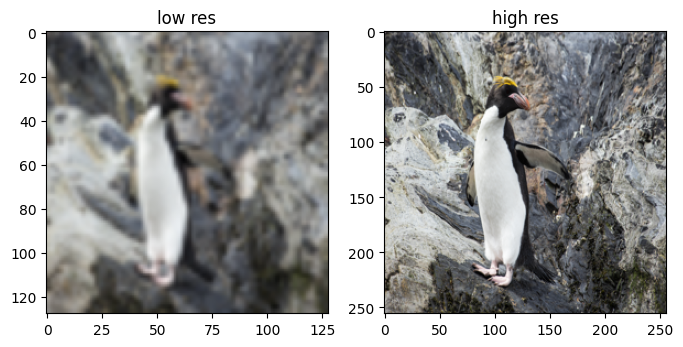

In [42]:
# Showing an image from the dataset
def show_image():
    dataset = ImageDataset(Config.root_dir+"/test",Config.test_lr_images_dir, Config.test_gt_images_dir)
    #print length of the dataset
    print(len(dataset))
    loader = DataLoader(dataset, batch_size=Config.batch_size, num_workers=Config.num_workers)
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for idx, (low_res, high_res) in enumerate(loader):
        # Display the first image in the left subplot
        axs[0].imshow(low_res[0].permute(1, 2, 0))
        axs[0].set_title("low res")

        # Display the second image in the right subplot
        axs[1].imshow(high_res[0].permute(1, 2, 0))
        axs[1].set_title("high res")

        if(idx == 0):
            break

    # Show the figure
    plt.show()
show_image()

# New Section

In [43]:
if torch.cuda.is_available():
    print("CUDA is available! GPU:", torch.cuda.get_device_name(0))
    torch.cuda.empty_cache()
else:
    print("CUDA is not available.")

CUDA is available! GPU: Tesla T4


In [44]:
class vggL(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:35].eval().to(Config.device)
        self.loss = nn.MSELoss()

    def forward(self, first, second):
        vgg_first = self.vgg(first)
        vgg_second = self.vgg(second)
        perceptual_loss = self.loss(vgg_first, vgg_second)
        return perceptual_loss

In [45]:
class ConvolutionalBlock(nn.Module):
    # Convolution -> Batch Normalization -> LeakyReLU (Optional)
    def __init__(
            self,
            input_channels,
            output_channels,
            apply_activation=True,
            apply_batch_norm=True,
            **conv_params
    ):
        super().__init__()

        self.apply_activation = apply_activation

        # Convolutional layer
        self.conv_layer = nn.Conv2d(input_channels, output_channels, **conv_params)

        # Batch Normalization layer (optional)
        self.batch_norm = nn.BatchNorm2d(output_channels) if apply_batch_norm else nn.Identity()

        # LeakyReLU activation (default)
        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        out = self.conv_layer(x)  # Apply convolution
        out = self.batch_norm(out)  # Apply batch normalization
        out1 = self.activation(out)  # Apply activation
        return out1 if self.apply_activation else out


class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()

        # Convolution layer
        self.conv = nn.Conv2d(in_channels, in_channels * scale_factor ** 2, kernel_size=2, stride=1, padding=1)

        # Pixel Shuffle layer for upsampling
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)

        # Parametric ReLU activation
        self.activation = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        # Apply convolution, pixel shuffle, and activation
        out = self.conv(x)
        out = self.pixel_shuffle(out)
        out = self.activation(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        # First convolution block
        self.conv_block1 = ConvolutionalBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            apply_activation=True,
            apply_batch_norm=True
        )

        # Second convolution block (without activation)
        self.conv_block2 = ConvolutionalBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            apply_activation=False,
            apply_batch_norm=True
        )

    def forward(self, x):
        # Apply both convolution blocks and add input to output (skip connection)
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        return out + x


In [46]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        blocks = []
        self.features = nn.Sequential(
            # input size. (3) x hr_height_size x hr_width_size
            # k3n64s1
            # nn.Conv2d(3, 64, (3, 3), (1, 1), (1, 1), bias=True),
            ConvolutionalBlock(in_channels, 64, kernel_size=3, stride=1, padding=1, apply_activation=True, apply_batch_norm=False),
            # state size. (64) x 48 x 48
            # k3n64s2
            ConvolutionalBlock(64, 64, kernel_size=3, stride=2, padding=1, apply_activation=True, apply_batch_norm=True),

            #k3n128s1
            ConvolutionalBlock(64, 128, kernel_size=3, stride=1, padding=1, apply_activation=True, apply_batch_norm=True),


            # state size. (128) x 24 x 24
            #k3n128s2
            ConvolutionalBlock(128, 128, kernel_size=3, stride=2, padding=1, apply_activation=True, apply_batch_norm=True),


            #k3n256s1
            ConvolutionalBlock(128, 256, kernel_size=3, stride=1, padding=1, apply_activation=True, apply_batch_norm=True),


            # state size. (256) x 12 x 12
            #k3n256s2
            ConvolutionalBlock(256, 256, kernel_size=3, stride=2, padding=1, apply_activation=True, apply_batch_norm=True),


            #k3n512s1
            ConvolutionalBlock(256, 512, kernel_size=3, stride=1, padding=1, apply_activation=True, apply_batch_norm=True),


            # state size. (512) x 6 x 6
            #k3n512s2
            ConvolutionalBlock(512, 512, kernel_size=3, stride=2, padding=1, apply_activation=True, apply_batch_norm=True),
        )


        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(512*8*8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        out = self.features(x)
        out = self.mlp(out)
        return out

In [47]:

class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=8):
        super().__init__()

        # Initial convolution block without BatchNorm
        self.initial_conv_block = ConvolutionalBlock(
            in_channels,
            num_channels,
            kernel_size=7,
            stride=1,
            padding=4,
            apply_batch_norm=False
        )

        # Create a list of residual blocks using a for loop
        trunk = []
        for _ in range(num_blocks):
            trunk.append(ResidualBlock(num_channels))

        # Combine all residual blocks into a sequential container
        self.residual_blocks = nn.Sequential(*trunk)

        # Convolution block after residual layers, without activation
        self.conv_block = ConvolutionalBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, apply_activation=False)

        # Upsampling block
        self.upsample_block = UpsampleBlock(num_channels, scale_factor=2)

        # Final convolution layer
        self.final_conv = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=1)

    def forward(self, x):
        # Pass through initial convolution block
        out1 = self.initial_conv_block(x)

        # Pass through residual blocks
        out = self.residual_blocks(out1)

        # Pass through convolution and add skip connection
        out = self.conv_block(out) + out1

        # Pass through upsampling block
        out = self.upsample_block(out)

        # Pass through final convolution and apply sigmoid
        return torch.sigmoid(self.final_conv(out))


In [48]:
class CUDAPrefetcher:
    """Use the CUDA side to accelerate data reading.
    Args:
        dataloader (DataLoader): Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset.
        device (torch.device): Specify running device.
    """

    def __init__(self, dataloader: DataLoader, device: torch.device):
        self.batch_data = None
        self.original_dataloader = dataloader
        self.device = device

        self.data_iter = iter(dataloader)  # Renamed for clarity, using the correct variable
        self.stream = torch.cuda.Stream()
        self.preload()

    def preload(self):
        try:
            self.batch_data = next(self.data_iter)
        except StopIteration:
            self.batch_data = None
            return None

        if self.batch_data is None:
            print("No data in the DataLoader")
            return

        with torch.cuda.stream(self.stream):
            if isinstance(self.batch_data, dict):
                # Iterate over key-value pairs if it's a dictionary
                for k, v in self.batch_data.items():
                    if torch.is_tensor(v):
                        self.batch_data[k] = self.batch_data[k].to(self.device, non_blocking=True)
                    elif isinstance(v, (list, tuple)):  # Move list/tuple of tensors to device
                        self.batch_data[k] = [x.to(self.device, non_blocking=True) for x in v if torch.is_tensor(x)]
            elif isinstance(self.batch_data, (list, tuple)):
                # Iterate over the list/tuple if batch_data is a list/tuple
                for idx, v in enumerate(self.batch_data):
                    if torch.is_tensor(v):
                        self.batch_data[idx] = v.to(self.device, non_blocking=True)
                    elif isinstance(v, (list, tuple)):
                        self.batch_data[idx] = [x.to(self.device, non_blocking=True) for x in v if torch.is_tensor(x)]

    def next(self):
        if self.batch_data is None:
            raise ValueError("DataLoader is empty.")
        torch.cuda.current_stream().wait_stream(self.stream)
        batch_data = self.batch_data
        self.preload()  # Preload next batch
        return batch_data

    def reset(self):
        self.data_iter = iter(self.original_dataloader)
        self.preload()

    def __len__(self) -> int:
        return len(self.original_dataloader)


In [49]:

def load_dataset(srgan_config: Config):
    # Load train, test and valid datasets
    train_datasets =ImageDataset(Config.root_dir+"/train",Config.train_lr_images_dir, Config.train_gt_images_dir)

    test_datasets = ImageDataset(Config.root_dir+"/test",Config.test_lr_images_dir, Config.test_gt_images_dir)


    print(f"Train dataset size path:{srgan_config.train_gt_images_dir} : {len(train_datasets)}")
    print(f"Test dataset size {srgan_config.test_gt_images_dir}: {len(test_datasets)}")
    # Generator all dataloader
    train_dataloader = DataLoader(
        train_datasets,
        batch_size=srgan_config.batch_size,
        shuffle=True,
        num_workers=Config.num_workers,
        pin_memory=True,
        drop_last=True,
        persistent_workers=True
        )
    test_dataloader = DataLoader(
        test_datasets,
        batch_size=srgan_config.batch_size,
        shuffle=False,
        num_workers=Config.num_workers,
        pin_memory=True,
        drop_last=False,
        persistent_workers=True
        )


    return train_dataloader, test_dataloader


In [53]:

from torch.amp import autocast, GradScaler # Import from torch.amp
from tqdm import tqdm  # Import tqdm

scaler = GradScaler()
class GANTrainer:
    def __init__(self, generator, discriminator, train_loader, val_loader, device, lr=Config.model_lr, betas=Config.model_betas, vgg_loss=None):

        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.lr = Config.model_lr
        self.betas = Config.model_betas

        # Optimizers
        self.optim_g = optim.Adam(self.generator.parameters(), lr=self.lr, betas=self.betas)
        self.optim_d = optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=self.betas)

        # Loss functions
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.vgg_loss = vgg_loss

        # Lists to track losses and PSNR
        self.d_losses = []
        self.g_losses = []
        self.psnrs = []
        self.pretrain_psnr=[]
        self.pretrain_genLoss=[]

    def calculate_psnr(self, pred, target, max_val=1.0):
        """
        Calculate Peak Signal-to-Noise Ratio (PSNR) between predicted and target images.
        :param pred: The predicted image
        :param target: The target image
        """
        mse = nn.functional.mse_loss(pred, target)
        psnr = 20 * torch.log10(max_val / torch.sqrt(mse))
        return psnr.item()


    def plot_examples(self):
        gen= self.generator
        dataset_test = ImageDataset(Config.root_dir+"/test",Config.test_lr_images_dir, Config.test_gt_images_dir)
        loader = DataLoader(dataset_test, batch_size=Config.batch_size, num_workers=Config.num_workers)

        # Create a figure with two subplots
        fig, axs = plt.subplots(1, 3, figsize=(8, 4))
        chosen_batch = random.randint(0, len(loader)-1)
        for idx, (low_res, high_res) in enumerate(loader):
            if(chosen_batch == idx):
                chosen = random.randint(0, len(low_res)-1)

                axs[0].set_axis_off()
                axs[0].imshow(low_res[chosen].permute(1, 2, 0))
                axs[0].set_title("low res")

                with torch.no_grad():
                    upscaled_img = gen(low_res[chosen].to(self.device).unsqueeze(0))

                axs[1].set_axis_off()
                axs[1].imshow(upscaled_img.cpu().permute(0, 2, 3, 1)[0])
                axs[1].set_title("predicted")

                axs[2].set_axis_off()
                axs[2].imshow(high_res[chosen].permute(1, 2, 0))
                axs[2].set_title("high res")

                if(idx == 1):
                    break

        # Show the figure
        plt.show()

        gen.train()


    def train_step(self, low_res, high_res):
      self.optim_d.zero_grad()
      self.optim_g.zero_grad()

      with autocast(device_type='cuda'):  # Use device_type='cuda'
          fake = self.generator(low_res)
          disc_real = self.discriminator(high_res)
          disc_fake = self.discriminator(fake.detach())

          disc_loss_real = self.bce(disc_real, torch.ones_like(disc_real))
          disc_loss_fake = self.bce(disc_fake, torch.zeros_like(disc_fake))
          disc_loss = disc_loss_fake + disc_loss_real

      # Scale and optimize discriminator
      scaler.scale(disc_loss).backward()
      scaler.step(self.optim_d)

      with autocast(device_type='cuda'):  # Use device_type='cuda'
          disc_fake = self.discriminator(fake)
          adversarial_loss = 1e-3 * self.bce(disc_fake, torch.ones_like(disc_fake))
          loss_for_vgg = 0.006 * self.vgg_loss(fake, high_res) if self.vgg_loss else 0
          gen_loss = loss_for_vgg + adversarial_loss

      # Scale and optimize generator
      scaler.scale(gen_loss).backward()
      scaler.step(self.optim_g)
      scaler.update()  # Update scaler

      psnr_value = self.calculate_psnr(fake, high_res)
      # print(f"Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")
      return gen_loss.detach().cpu(), disc_loss.detach().cpu(), psnr_value

    def train_generator(self, low_res, high_res):
        self.optim_g.zero_grad()

        with autocast(device_type='cuda'):
            fake = self.generator(low_res)
            recon_loss = torch.nn.functional.l1_loss(fake, high_res)

            # Optionally add VGG loss if needed (you already have this in your code)
            vgg_loss = 0.006 * self.vgg_loss(fake, high_res) if self.vgg_loss else 0

            # Total generator loss
            gen_loss = recon_loss + vgg_loss

        # Scale and optimize generator
        scaler.scale(gen_loss).backward()
        scaler.step(self.optim_g)
        scaler.update()

        psnr_value = self.calculate_psnr(fake, high_res)
        return gen_loss.detach().cpu(), psnr_value

    def train(self, epochs, save_interval=5, plot_interval=1, eval_interval=10):
        """Train the GAN model."""
        train_prefetcher = CUDAPrefetcher(train_loader, device)
        print("length of train prefetcher: " + str(len(train_prefetcher)))
        best_psnr=0.0
        pre_train_gen_epochs=100
        for epoch in range(pre_train_gen_epochs):
            self.generator.train()
            total_psnr = 0
            num_batches = 0
            epoch_gen_loss = 0

            with tqdm(total=len(train_prefetcher), desc=f"Pre-training Generator Epoch {epoch+1}/{pre_train_gen_epochs}", unit="batch") as pbar:
                for batch_index in range(len(train_prefetcher)):
                    try:
                        batch_data = train_prefetcher.next()
                        low_res = batch_data[0]
                        high_res = batch_data[1]

                        gen_loss, psnr_value = self.train_generator(low_res, high_res)

                        total_psnr += psnr_value
                        num_batches += 1
                        epoch_gen_loss += gen_loss.item()

                        pbar.set_postfix({"gen_loss": f"{gen_loss.item():.4f}", "psnr": f"{psnr_value:.4f}"})
                        pbar.update(1)

                    except Exception as e:
                        print(f"Error in pre-training loop: {e}")
                        break
                train_prefetcher.reset()
            avg_psnr = total_psnr / num_batches
            avg_gen_loss = epoch_gen_loss / num_batches
            self.pretrain_psnr.append(avg_psnr)
            self.pretrain_genLoss.append(avg_gen_loss)
            if epoch%10==0:
              print(f"Pre-training Epoch {epoch+1}/{pre_train_gen_epochs}: Generator Loss: {avg_gen_loss:.4f}, Avg PSNR: {avg_psnr:.4f}")
              self.plot_examples()

        for epoch in range(epochs):
            self.generator.train()
            self.discriminator.train()
            total_psnr = 0
            num_batches = 0
            epoch_gen_loss = 0
            epoch_disc_loss = 0

            # Wrap the loop with tqdm
            with tqdm(total=len(train_prefetcher), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:  # Use tqdm here
                for batch_index in range(len(train_prefetcher)):
                    try:
                        batch_data = train_prefetcher.next()
                        low_res = batch_data[0]
                        high_res = batch_data[1]

                        gen_loss, disc_loss, psnr_value = self.train_step(low_res, high_res)

                        total_psnr += psnr_value
                        num_batches += 1
                        epoch_gen_loss += gen_loss.item()
                        epoch_disc_loss += disc_loss.item()

                        pbar.set_postfix({"gen_loss": f"{gen_loss.item():.4f}", "disc_loss": f"{disc_loss.item():.4f}", "psnr": f"{psnr_value:.4f}"}) # Update tqdm postfix
                        pbar.update(1) # Update the tqdm bar

                    except Exception as e:
                        print(f"Error in training loop: {e}")
                        import traceback
                        traceback.print_exc()
                        break

            train_prefetcher.reset()

            avg_psnr = total_psnr / num_batches
            avg_gen_loss = epoch_gen_loss / num_batches
            avg_disc_loss = epoch_disc_loss / num_batches
            self.psnrs.append(avg_psnr)
            self.g_losses.append(avg_gen_loss)
            self.d_losses.append(avg_disc_loss)
            print(
                f"Epoch {epoch+1}/{epochs}: "
                f"Generator Loss: {avg_gen_loss:.4f}, "
                f"Discriminator Loss: {avg_disc_loss:.4f}, "
                f"Avg PSNR: {avg_psnr:.4f}"
            )

            self.plot_examples()



            # Optionally evaluate on validation set
            if (epoch + 1) % eval_interval == 0:
                best_psnr = self.evaluate(epoch,best_psnr=best_psnr)

    def save_models(self, epoch, path="models"):

        torch.save(self.generator.state_dict(), f"{path}/generator_epoch_{epoch}.pth")
        torch.save(self.discriminator.state_dict(), f"{path}/discriminator_epoch_{epoch}.pth")


    def evaluate(self, epoch,best_psnr=0.0, save_path="models"):  # Add best_psnr and save_path
        """Evaluate and save the generator if it performs better."""
        val_prefetcher = CUDAPrefetcher(self.val_loader, self.device)  # Use self.val_loader
        self.generator.eval()
        total_psnr = 0
        num_batches = 0

        with torch.no_grad():
            for batch_index in range(len(val_prefetcher)):
                try:
                    batch_data = val_prefetcher.next()
                    low_res = batch_data[0]  # Access by key
                    high_res = batch_data[1]  # Access by key
                    fake = self.generator(low_res)
                    psnr_value = self.calculate_psnr(fake, high_res)
                    total_psnr += psnr_value
                    num_batches += 1
                except StopIteration: # Handle end of epoch
                    break
                except Exception as e:
                    print(f"Error in evaluation loop: {e}")
                    import traceback
                    traceback.print_exc()
                    break

        val_prefetcher.reset() # Reset the prefetcher

        avg_psnr = total_psnr / num_batches
        print(f"Validation PSNR: {avg_psnr:.4f}")

        if avg_psnr > best_psnr:
            print(f"Saving generator model (improved PSNR: {avg_psnr:.4f} > {best_psnr:.4f})")
            os.makedirs(save_path, exist_ok=True)  # Create directory if it doesn't exist
            self.save_models(epoch) # Save as generator_best.pth
            best_psnr = avg_psnr  # Update best PSNR

        self.generator.train()
        return best_psnr # Return best PSNR


In [54]:
# Load the GAN Trainer
vgg_loss = vggL()
generator = Generator()
discriminator = Discriminator()
# Load training & validation data using CUDA Prefetcher
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()
train_loader, val_loader = load_dataset(Config)
trainer = GANTrainer(generator, discriminator, train_loader, val_loader, device, vgg_loss=vgg_loss)


Train dataset size path:/content/gdrive/My Drive/AI534/dataset/train/high_res : 401
Test dataset size /content/gdrive/My Drive/AI534/dataset/test/high_res: 100


In [55]:
trainer.train(100, eval_interval=10)

Output hidden; open in https://colab.research.google.com to view.

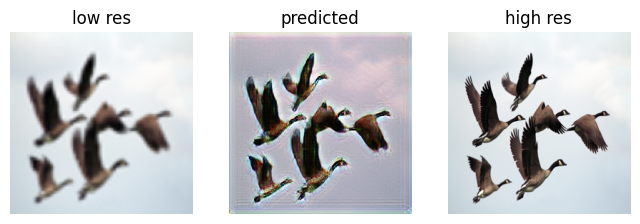

In [56]:
trainer.plot_examples()

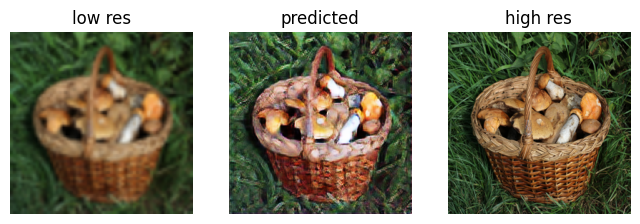

In [58]:
trainer.plot_examples()

In [60]:
torch.save(generator.state_dict(), "/content/gdrive/MyDrive/AI534/dataset/checkpoint1_gen")
torch.save(discriminator.state_dict(), "/content/gdrive/MyDrive/AI534/datasetcheckpoint1_disc")

In [98]:
def plot_examples():
    gen = trainer.generator
    dataset_test = ImageDataset(Config.root_dir + "/test", Config.test_lr_images_dir, Config.test_gt_images_dir)

    # Set up the figure for 25 images
    val=25
    fig, axs = plt.subplots(val, 3, figsize=(8, 50 * 1.5))

    count = 0
    for idx in range(len(dataset_test)):  # Iterate through the dataset directly
        if count>=val:
          break
        low_res, high_res = dataset_test[idx]

        # Plot low resolution image
        axs[count, 0].imshow(low_res.permute(1, 2, 0).cpu().numpy())  # Convert to numpy
        axs[count, 0].set_title("Low Res")
        axs[count, 0].axis('off')

        # Generate the predicted upscaled image
        with torch.no_grad():
            upscaled_img = gen(low_res.to(device).unsqueeze(0))  # Add batch dimension

        # Plot predicted (upscaled) image
        axs[count, 1].imshow(upscaled_img.cpu().permute(0, 2, 3, 1)[0].numpy())  # Convert to numpy
        axs[count, 1].set_title("Predicted")
        axs[count, 1].axis('off')

        # Plot the high resolution ground truth image
        axs[count, 2].imshow(high_res.permute(1, 2, 0).cpu().numpy())  # Convert to numpy
        axs[count, 2].set_title("High Res")
        axs[count, 2].axis('off')

        count += 1

    # Show the figure
    plt.tight_layout()
    plt.show()


In [99]:
plot_examples()

Output hidden; open in https://colab.research.google.com to view.

In [92]:
plot_examples()

Output hidden; open in https://colab.research.google.com to view.